In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 #Use the GPU memory 50%
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob #inside the folders how many sub folders are present?


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

#train_path = 'Datasets/train'
#valid_path = 'Datasets/test'

train_path='C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\train'
valid_path='C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\test'

In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
#Preprocessing  - reuse with some modifications
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#Here i am going to take the weights, what ever weights they had stored during training iam going to retreive those weights 
#If we failed to provide the weights('Imagenet') then it starts the training from Scratch.
#include_top = False -->  Default 1000 outputs but in our case only 2 outputs, It skips the flatten and output layer and we can add our own flatten layer and output layer
#include_top=True(which means - whole architecture - input,flatten,output from the VGG16 for Imagenet classification)


In [5]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# don't train existing weights
# Dont train the weights from scratch or dont update the weight and my weights are fixed.
for layer in vgg16.layers:
    layer.trainable = False

In [7]:
  # useful for getting number of output classes
#folders = glob('Datasets/train/*')
folders = glob('C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\train\*')
folders

['C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\train\\diseased cotton leaf',
 'C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\train\\diseased cotton plant',
 'C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\train\\fresh cotton leaf',
 'C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\train\\fresh cotton plant']

In [8]:
# Flatten Layer
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [9]:
#Output Layer
prediction = Dense(len(folders), activation='softmax')(x) # x - appending my flatten layer(x) with dense layer

# create a model object  by combining the entire input's and output's to create the dense neural network
#Here vgg16 is the model or variable that we have created early
model = Model(inputs=vgg16.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [11]:
#multiclass classification(softmax) - so we have used categorical_crossentropy as a loss function
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [14]:
test_set = test_datagen.flow_from_directory('C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 106 images belonging to 4 classes.


In [24]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

61/61 [==============================] - 27s 450ms/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 0.0769 - val_accuracy: 0.9623


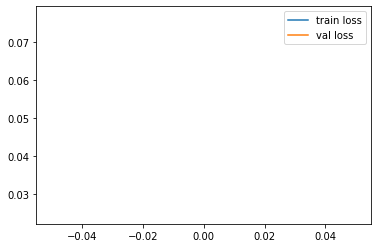

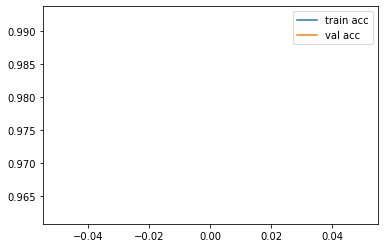

<Figure size 432x288 with 0 Axes>

In [25]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [26]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('model_vgg16_CottonDisease.h5')

In [27]:
#Prediction
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('model_vgg16_CottonDisease.h5')

In [28]:
test_image = image.load_img('C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\test\\diseased cotton plant\\dd (895)_iaip.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
#covert the array values in to noramalize values
test_image=test_image/255
#Exapnd the dimensions
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image) 

In [29]:
result

array([[2.0887417e-05, 9.9369872e-01, 1.5739720e-06, 6.2787849e-03]],
      dtype=float32)

In [32]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('C:\\Users\\Asus-2020\\Downloads\\Cotton Disease\\test\\diseased cotton plant\\dd (895)_iaip.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#a=np.argmax(model.predict(test_image), axis=1)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'diseased cotton leaf'
    print(prediction)
elif result[0][1]==1:
    prediction="diseased cotton plant"
    print(prediction)
elif result[0][2]==1:
    prediction="fresh cotton leaf"
    print(prediction)

else:
    prediction = 'fresh cotton plant'
    print(prediction)

diseased cotton plant
